In [1]:
import numpy as np
import cv2
import os
from glob import glob
import matplotlib.pyplot as plt
from cpp.generated.default.release import PyTACELib
from skimage.morphology import skeletonize
import scipy as sp
import time

In [2]:
segs = glob(os.path.join('../i2i/EntireData', '**/fluoroSeg/*.png'), recursive=True)
segs.sort()

In [3]:
THRESHOLD_BINARY = 0.01
# THRESHOLD_BINARY = 0.5
PYTACELIB_DEBUG_OUTPUT = False

SIZE_X = 256
SIZE_Y = 256

NB_CHANNEL = 4
SMALL_POSITIVE_NUMBER = 1e-7
def GetCenterline(_image, _imgInfo = None, renorm=True, bnot=True):
    if bnot:
        _image = cv2.bitwise_not(_image)
    image = _image / 255.0
    
    image[image > THRESHOLD_BINARY] = 1
    image[image <= THRESHOLD_BINARY] = 0
    if _imgInfo != None:
        image = image[_imgInfo[INFO_PAD_Y] + _imgInfo[INFO_DIAPHRAGM_Y1]:_imgInfo[INFO_PAD_Y] + _imgInfo[INFO_DIAPHRAGM_Y2] + 1,_imgInfo[INFO_PAD_X] + _imgInfo[INFO_DIAPHRAGM_X1]:_imgInfo[INFO_PAD_X] + _imgInfo[INFO_DIAPHRAGM_X2] + 1]
    image = skeletonize(image)
    # print("image.dtype " + str(image.dtype))

    if renorm:
        image = (image*255).astype(np.uint8)
	# SaveImage("generated/debug.png", image)
    if PYTACELIB_DEBUG_OUTPUT == True:
        centerline, debugStepList = PyTACELib.ExtractCenterline(image)
    else:
        centerline = PyTACELib.ExtractCenterline(image)

    centerline = np.array(centerline)
    if centerline.shape[0] > 3:
        centerline = np.swapaxes(centerline, 0, 1)

        tck,u = sp.interpolate.splprep([centerline[0], centerline[1]], k=3)
        x, y = sp.interpolate.splev(np.linspace(0, 1, len(centerline[0])), tck)
        # print("x.shape " + str(x.shape))
        # print("y.shape " + str(y.shape))
        centerline = np.stack((x, y))
        centerline = np.swapaxes(centerline, 0, 1)
        # print("centerline.shape " + str(centerline.shape))
        # print(centerline[:5])
    if _imgInfo != None:
        centerline = centerline + (_imgInfo[INFO_PAD_X] + _imgInfo[INFO_DIAPHRAGM_X1], _imgInfo[INFO_PAD_Y] + _imgInfo[INFO_DIAPHRAGM_Y1])
    centerline = centerline.clip((0, 0), (_image.shape[1] - SMALL_POSITIVE_NUMBER, _image.shape[0] - SMALL_POSITIVE_NUMBER))

    if PYTACELIB_DEBUG_OUTPUT == True:
        return centerline, debugStepList
        
    return centerline

In [4]:
def find_tip(line):
    c1 = line[0]
    c2 = line[-1]
    
    d1 = np.linalg.norm(c1)
    d2 = np.linalg.norm(c2)
    
    if d1 > d2:
        return c1.astype(np.int)
    else:
        return c2.astype(np.int)

48 23 [0 0]


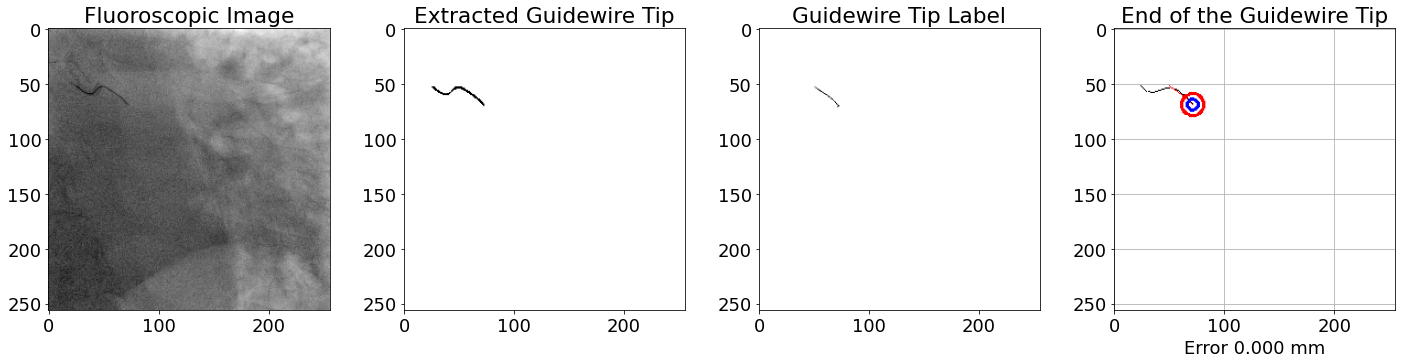

In [12]:
#idx = np.random.choice(np.arange(0,len(segs)))
#idx =1352 # Worst
idx = 17
img = cv2.imread(segs[idx], cv2.IMREAD_GRAYSCALE)
flu = cv2.imread(segs[idx].replace('fluoroSeg', 'fluoroReal'), cv2.IMREAD_GRAYSCALE)
flu = cv2.resize(flu, (256,256))
lab = cv2.imread(segs[idx].replace('fluoroSeg', 'fluoroTip'), cv2.IMREAD_GRAYSCALE)
lab = cv2.resize(lab, (256,256))

test = GetCenterline(img)
timg = np.ones((256,256,3), np.uint8) * 255

label = GetCenterline(lab)

seg_tip = find_tip(test)
lab_tip = find_tip(label)

for i in range(len(test)):
    x, y = test[i]
    x = int(x)
    y = int(y)
    timg[y,x] = [0,0,0]

for i in range(len(label)):
    x, y = label[i]
    x = int(x)
    y = int(y)
    timg[y,x] = [0,0,255]
    
diff = lab_tip - seg_tip
diff_mm = diff * 0.258390625 * 2
dist = np.linalg.norm(diff_mm)

cv2.circle(timg, seg_tip, 5, (255,0,0), 2)
cv2.circle(timg, lab_tip, 10, (0,0,255), 2)

print(len(test), len(label), seg_tip-lab_tip)
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(20,5))
plt.subplot(141)
plt.imshow(flu, cmap='gray')
#plt.axis('off')
plt.title('Fluoroscopic Image')

plt.subplot(142)
plt.imshow(img, cmap='gray')
#plt.axis('off')
plt.title('Extracted Guidewire Tip')

plt.subplot(143)
plt.imshow(lab, cmap='gray')
#plt.axis('off')
plt.title('Guidewire Tip Label')

plt.subplot(144)
plt.imshow(cv2.cvtColor(timg, cv2.COLOR_BGR2RGB))
#plt.axis('off')
plt.title('End of the Guidewire Tip')
plt.xlabel('Error %.3f mm'%dist)
plt.grid()
plt.tight_layout()
#plt.savefig('seg_worst.png')
plt.savefig('seg_exam.png')
plt.show()

In [9]:
errors = []
for i in range(len(segs)):
    if i % 500 == 0:
        print(i, len(segs)-1)
    img = cv2.imread(segs[i], cv2.IMREAD_GRAYSCALE)
    lab = cv2.imread(segs[i].replace('fluoroSeg', 'fluoroTip'), cv2.IMREAD_GRAYSCALE)
    lab = cv2.resize(lab, (256,256))

    test = GetCenterline(img)
    timg = np.ones((256,256,3), np.uint8) * 255

    label = GetCenterline(lab)

    seg_tip = find_tip(test)
    lab_tip = find_tip(label)

    diff = lab_tip - seg_tip
    diff_mm = diff * 0.258390625 * 2
    dist = np.linalg.norm(diff_mm)
    errors.append(dist)
errors = np.array(errors)
print(np.mean(errors), np.std(errors), np.median(errors), np.max(errors), np.min(errors))

0 4980
500 4980
1000 4980
1500 4980
2000 4980
2500 4980
3000 4980
3500 4980
4000 4980
4500 4980
1.6298147122616735 4.83677820111633 0.7308390525301209 95.22807614405352 0.0


In [10]:
np.argmax(errors)

1352

In [11]:
np.argmin(errors)

17